# Analysis of 77084 zip code using Facebook Prophet

# Imports and loading csv

In [168]:
from fbprophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
#Supress default INFO logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
logging.disable(sys.maxsize)
from fbprophet.diagnostics import cross_validation
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
%matplotlib inline

In [169]:
df=pd.read_csv('Data Files/df_zillow_77084_prepped_fbprophet.csv')

In [170]:
df.head()

,ds,y
0,1996-04,95000.0
1,1996-05,95200.0
2,1996-06,95400.0
3,1996-07,95700.0
4,1996-08,95900.0


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      265 non-null    object 
 1   y       265 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.3+ KB


In [172]:
df.rolling(window=2).mean().head()

,y
0,NaN
1,95100.0
2,95300.0
3,95550.0
4,95800.0


In [173]:
df['roll_avg'] = df.rolling(window=2).mean()
df.corr()

,y,roll_avg
y,1.000000,0.999888
roll_avg,0.999888,1.000000


In [174]:
# df

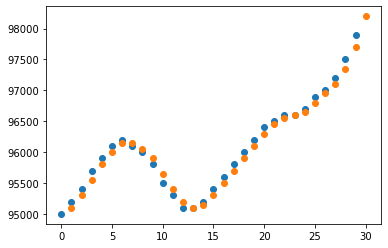

In [175]:
plt.scatter(df.index[:30], df['y'][:30])
plt.scatter(df.index[1:31], df['roll_avg'][1:31]);

In [176]:
lr = LinearRegression()

lr.fit(df[['roll_avg']][1:], df['y'][1:])

LinearRegression()

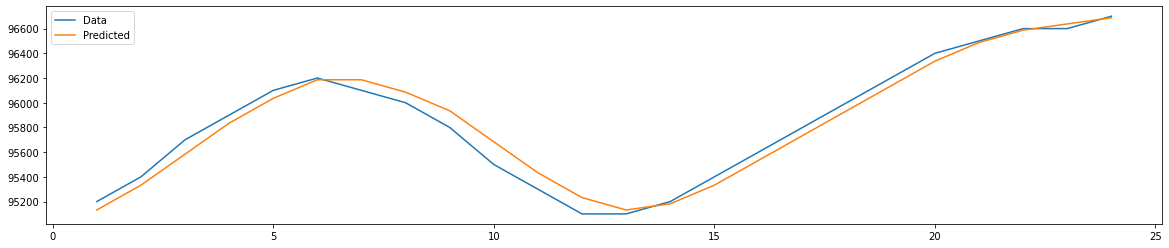

In [177]:
plt.figure(figsize=(20, 4))
plt.plot(df.index[1:25], df['y'][1:25], label='Data')
plt.plot(df.index[1:25], lr.predict(df[['roll_avg']][1:25]),
         label='Predicted')
plt.legend();

# Checking for Stationarity

Dickey-Fuller Test
Statistical test for testing stationarity; $H_0$ is that time series is not stationary

In [178]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df.y)
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-1.0526382056245156, 0.7335852181016426, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 3301.1131948148727)


In [179]:
print(dfoutput)

Test Statistic                  -1.052638
p-value                          0.733585
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


## We see from the Dickey-Fuller Test above that:

The Dickey-Fuller Test
The Dickey-Fuller test is a statistical test for testing stationarity. The null-hypothesis for the test is that the time series is not stationary. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary. The Dickey-Fuller test is available in tsa.stattools sub-module of the statsmodels library. More details on this can be viewed here.

We see that test statistic value is -1.052638
We see that the critical values are LESS than the test statistic. (-3.45, -2.87, -2.57)

### The test statistic I have is MORE than the critical value. We accept the null-hypothesis that the time series is not stationary! 


## P-Value analysis

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
### The p value is 0.733
### p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

# Auto-Correlation and Partial Auto-Correlation Check

In [149]:
acf(df['y'], nlags=20, fft=False)

array([1.        , 0.98320081, 0.96581333, 0.94786212, 0.92920807,
       0.9098244 , 0.88974082, 0.86943976, 0.84933628, 0.82935796,
       0.80910934, 0.78824935, 0.76673984, 0.74466391, 0.72219496,
       0.69940295, 0.67631589, 0.65306276, 0.6298105 , 0.60623204,
       0.58207846])

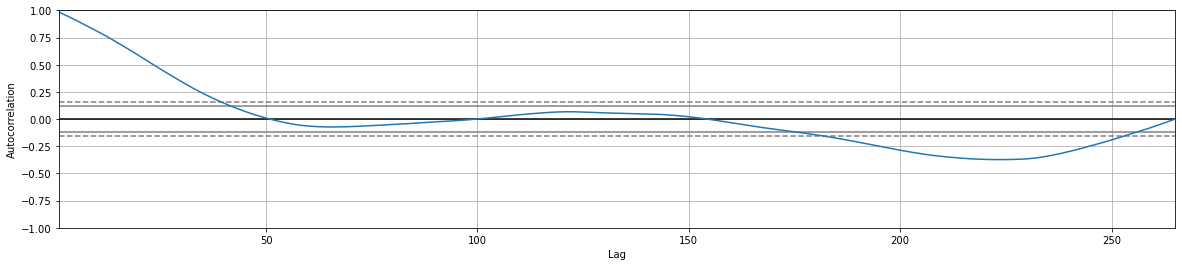

In [150]:
plt.figure(figsize=(20, 4))
pd.plotting.autocorrelation_plot(df['y']);

### Observations of the autocorrelation plot:



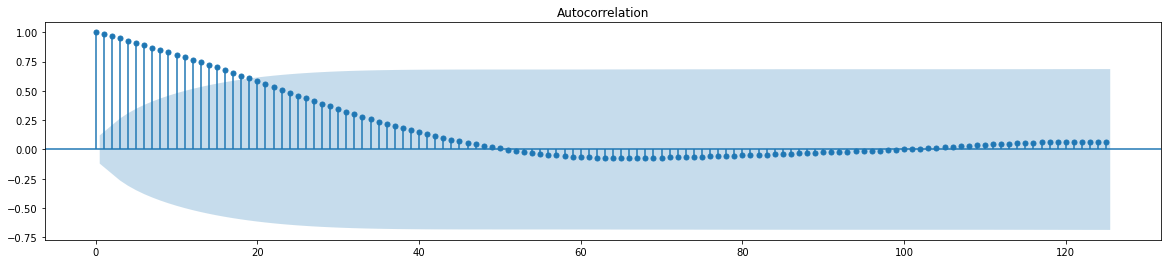

In [151]:
#We can also use the plot_acf() function from statsmodels:
rcParams['figure.figsize'] = 20, 4

plot_acf(df['y'], lags=125, alpha=0.05);

# Observations of ACF

## We see the following:

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

After about 20 lags, the line goes into our confidence interval (light blue area). 
This can be due to seasonality of every 20 months in our data.

anything outside confidence interval means not due to chance - reject null
What is the null that we are rejecting?
The null hypothesis that the series in question is NOT stationary.


We are rejecting that null.


## PACF

In [152]:
pacf(df['y'], nlags=20)

array([ 1.        ,  0.98692505, -0.0332246 , -0.03230274, -0.03785555,
       -0.03894804, -0.03787533, -0.01884109, -0.00271759, -0.00632691,
       -0.02312715, -0.037813  , -0.04009595, -0.03688473, -0.02918284,
       -0.02561189, -0.02460965, -0.02062068, -0.01556023, -0.0308752 ,
       -0.04218313])

In [153]:
row1 = acf(df['y'], nlags=1, fft=False)
row2 = acf(df['y'], nlags=1, fft=False)[::-1]

autos = np.vstack([row1, row2])
autos

array([[1.        , 0.98320081],
       [0.98320081, 1.        ]])

In [154]:
b = acf(df['y'], nlags=2, fft=False)[1:]

In [155]:
np.linalg.solve(autos, b)[-1]

-0.026128320340233397

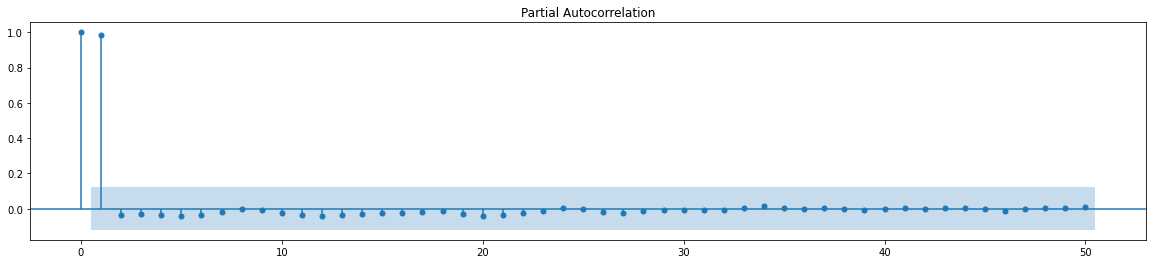

In [156]:
rcParams['figure.figsize'] = 20, 4

plot_pacf(df['y'], lags=50, alpha=0.05);

# Observations from PACF

## We see the following:
We know that the PACF only describes the direct relationship between an observation and its lag.

PACF cuts off after lags = 2
This means there are no correlations for lags beyond 2

## Rolling Mean check

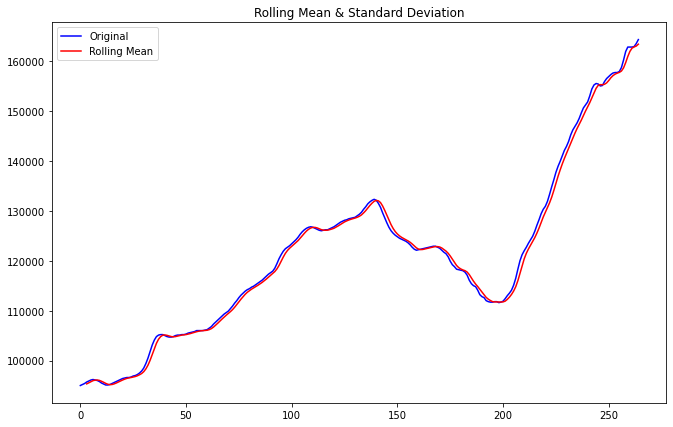

In [157]:
roll_mean = df['y'].rolling(window=4).mean()
fig = plt.figure(figsize=(11,7))
plt.plot(df['y'], color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [180]:
data_minus_roll_mean = df['y'] - roll_mean
data_minus_roll_mean.head(15)

# data_minus_roll_mean1 = df['y'] - roll_mean

0       NaN
1       NaN
2       NaN
3     375.0
4     350.0
5     325.0
6     225.0
7      25.0
8    -100.0
9    -225.0
10   -350.0
11   -350.0
12   -325.0
13   -150.0
14     25.0
Name: y, dtype: float64

In [181]:
# Drop the missing values from time series calculated above
data_minus_roll_mean.dropna(inplace=True)

In [160]:
df = df.drop(columns='roll_avg')

In [161]:
df.index = pd.to_datetime(df['ds'])

In [87]:
df= df.drop(columns='ds')

In [88]:
df.head()

,y
ds,
1996-04-01,95000.0
1996-05-01,95200.0
1996-06-01,95400.0
1996-07-01,95700.0
1996-08-01,95900.0


In [89]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['y'])

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [90]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

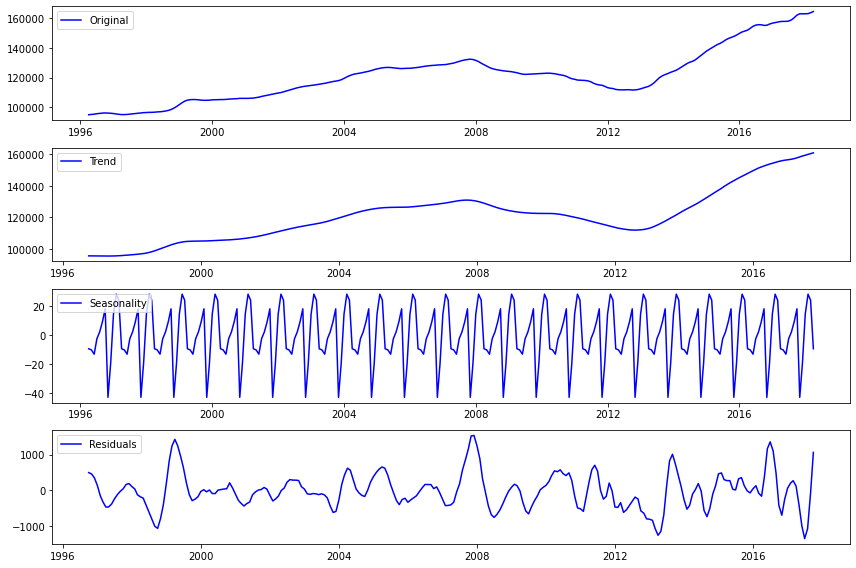

In [91]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [92]:
residual.mean()

-17.002615440107146

In [93]:
myst = 0
for i in range(len(df['y'])):
    myst += np.nansum(df['y'][i] - trend[i] - seasonal[i] - residual[i])
myst

0.0

# Detrend with log transform

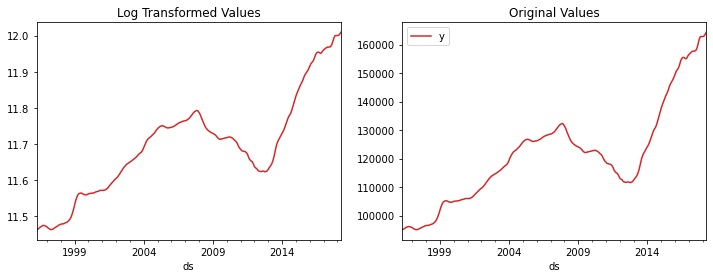

In [130]:
# logged_passengers = air_passengers["#Passengers"].apply(lambda x : np.log(x))

logged_df = df['y'].apply(lambda x : np.log(x))

ax1 = plt.subplot(121)
logged_df.plot(figsize=(12,4) ,color="tab:red", title="Log Transformed Values", ax=ax1);
ax2 = plt.subplot(122)
df.plot(color="tab:red", title="Original Values", ax=ax2);

In [163]:
# data_minus_roll_mean

dftest = adfuller(logged_df)
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-1.2051234223665381, 0.671387870792054, 13, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, -2519.397286409148)


In [164]:
print(dfoutput)

Test Statistic                  -1.205123
p-value                          0.671388
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


Test stat is still larger than crits
P value got lower to 0.67 now

In [200]:
logged_df

ds
1996-04-01    11.461632
1996-05-01    11.463735
1996-06-01    11.465834
1996-07-01    11.468974
1996-08-01    11.471061
                ...    
2017-12-01    12.000278
2018-01-01    12.000278
2018-02-01    12.000892
2018-03-01    12.004568
2018-04-01    12.009449
Name: y, Length: 265, dtype: float64

# De-trend and decompose again #2

In [191]:
#Try breakdown with data minus rollmean. It looks like there is seasonality but I want to try with roll mean removed
# data_minus_roll_mean
logged_df_roll_mean = logged_df.rolling(window=4).mean()

data_minus_roll_mean1 = logged_df - logged_df_roll_mean
data_minus_roll_mean1.dropna(inplace=True)

In [192]:
data_minus_roll_mean1

ds
1996-07-01    0.003930
1996-08-01    0.003660
1996-09-01    0.003391
1996-10-01    0.002344
1996-11-01    0.000261
                ...   
2017-12-01    0.005411
2018-01-01    0.001386
2018-02-01    0.000461
2018-03-01    0.003064
2018-04-01    0.005653
Name: y, Length: 262, dtype: float64

In [193]:
data_minus_roll_mean1

dftest = adfuller(data_minus_roll_mean1)
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-2.401036439819928, 0.14144409487084797, 13, 248, {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}, -2627.634694224994)


In [194]:
print(dfoutput)

Test Statistic                  -2.401036
p-value                          0.141444
#Lags Used                      13.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


## Dickey fuller test observations again:

Test statistic is -2.66, it is larger than critical values
    
    
    
Our p-value is 0.14
p-value is still > 0.05
we fail to reject null
Data still has unit root and is non stationary

In [196]:
decomposition = seasonal_decompose(data_minus_roll_mean1)

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [197]:
register_matplotlib_converters()

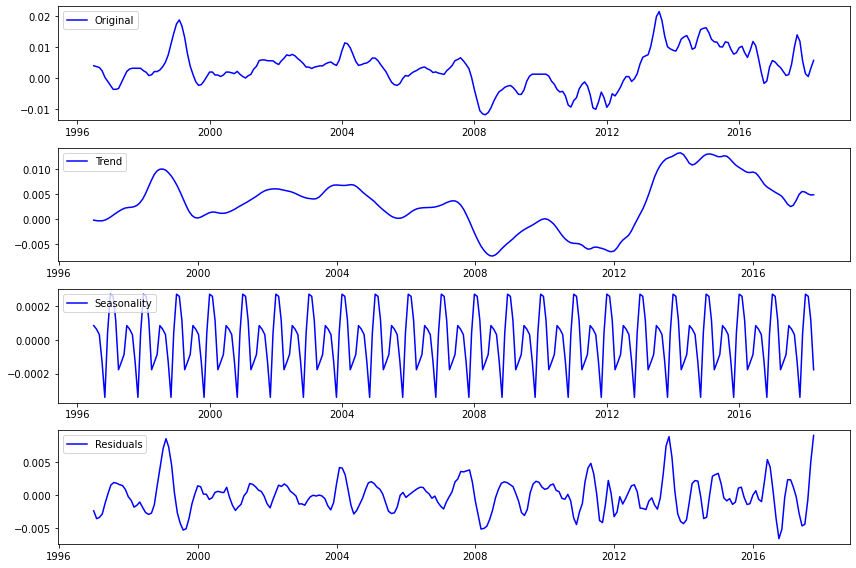

In [198]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [199]:
residual.mean()

-1.2433229374335233e-05

We see residual mean is VERY close to zero. 

We also see that p value decreased from 0.6 to 0.14. We are getting close to stationarity.


## third time is the charm? Detrending again.

So I did so far - I logged the data and subtracted rolling mean from it. 

I will try: 
1) What if i Increase the window? and then do a rolling mean subtraction of the data?
 - I tried windows of 10, 11, 12, and finally 13
2) And then do logged transform of the data and then check dickey fuller tests

In [225]:
roll_mean = df['y'].rolling(window=13).mean()
data_minus_roll_mean = df['y'] - roll_mean 

In [226]:
data_minus_roll_mean_logged = data_minus_roll_mean.apply(lambda x : np.log(x))

In [227]:
data_minus_roll_mean_logged.dropna(inplace=True)

In [228]:
dftest = adfuller(data_minus_roll_mean_logged)
# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-3.6872984128990565, 0.004295402264793401, 3, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, 156.80650099667866)


In [229]:
print(dfoutput)

Test Statistic                  -3.687298
p-value                          0.004295
#Lags Used                       3.000000
Number of Observations Used    186.000000
Critical Value (1%)             -3.466005
Critical Value (5%)             -2.877208
Critical Value (10%)            -2.575122
dtype: float64


## Viola. 

Test statistic is -3.68 which is lower than the critical values. We can reject the null hypothesis. So if the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary. 

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

## ARMA Modeling


ARMA Modeling
Number of AR (Auto-Regressive) terms (p):

AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
Number of MA (Moving Average) terms (q):

MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
Number of Differences (d):

These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

In [238]:

# Instantiate & fit model with statsmodels
p = 20 # num lags
q = 1 # lagged forecast errors

# This model will have 2 auto-regressive terms and one moving-average term.

ar = ARMA(data_minus_roll_mean_logged.diff().values[1:], (p, q)).fit()

In [239]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  189
Model:                    ARMA(20, 1)   Log Likelihood                 -75.600
Method:                       css-mle   S.D. of innovations              0.360
Date:                Wed, 28 Apr 2021   AIC                            197.200
Time:                        08:16:29   BIC                            271.760
Sample:                             0   HQIC                           227.406
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0097      0.013      0.739      0.460      -0.016       0.035
ar.L1.y        0.9463      0.235      4.019      0.000       0.485       1.408
ar.L2.y       -0.3479      0.115     -3.013      0.003      -0.574      -0.122
ar.L3.y        0.2584      0.110      2.348      0.019       0.043       0.474
ar.L4.y       -0.2160      0.110     -1.963      0.050      -0.432      -0.000
ar.L5.y       -0.0039      0.109     -0.036      0.971      -0.217       0.209
ar.L6.y       -0.0398      0.107     -0.372      0.710      -0.250       0.170
ar.L7.y        0.0239      0.107      0.223      0.824      -0.187       0.234
ar.L8.y       -0.0386      0.106     -0.365      0.715      -0.246       0.168
ar.L9.y        0.0050      0.106      0.047      0.962      -0.203       0.213
ar.L10.y      -0.0490      0.105     -0.465      0.642      -0.255       0.157
ar.L11.y       0.0051      0.106      0.048      0.961      -0.202       0.212
ar.L12.y       0.0002      0.105      0.002      0.999      -0.205       0.206
ar.L13.y       0.0063      0.104      0.061      0.951      -0.198       0.210
ar.L14.y      -0.0301      0.104     -0.290      0.772      -0.233       0.173
ar.L15.y      -0.0017      0.104     -0.017      0.987      -0.205       0.201
ar.L16.y      -0.0196      0.103     -0.190      0.849      -0.222       0.183
ar.L17.y      -0.0291      0.102     -0.285      0.775      -0.228       0.170
ar.L18.y      -0.0196      0.101     -0.194      0.846      -0.218       0.179
ar.L19.y      -0.0309      0.097     -0.320      0.749      -0.220       0.159
ar.L20.y      -0.0397      0.085     -0.466      0.641      -0.207       0.127
ma.L1.y       -0.7049      0.225     -3.134      0.002      -1.146      -0.264
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0250           -0.2006j            1.0444           -0.0308
AR.2             1.0250           +0.2006j            1.0444            0.0308
AR.3             0.9444           -0.4707j            1.0552           -0.0736
AR.4             0.9444           +0.4707j            1.0552            0.0736
AR.5             0.8069           -0.7874j            1.1275           -0.1231
AR.6             0.8069           +0.7874j            1.1275            0.1231
AR.7             0.5701           -1.0348j            1.1814           -0.1699
AR.8             0.5701           +1.0348j            1.1814            0.1699
AR.9             0.1816           -1.1799j            1.1937           -0.2257
AR.10            0.1816           +1.1799j            1.1937            0.2257
AR.11           -0.1495           -1.1877j            1.1970           -0.2699
AR.12           -0.1495           +1.1877j            1.1970            0.2699
AR

In [240]:
r2_score(data_minus_roll_mean_logged.diff().values[1:], ar.predict())

0.1532159517274645

We see r^2 value of 0.08 which is not that high, we would need more work on the model to get it to wherwe want it.

I ran it again with p = 20 and eh it is ok i guess. only went up to 0.15. 

Future work would be to see if I can get this part better. 

# Plotting the specific zip code data from csv

Text(0, 0.5, 'Home Values')

<Figure size 432x288 with 0 Axes>

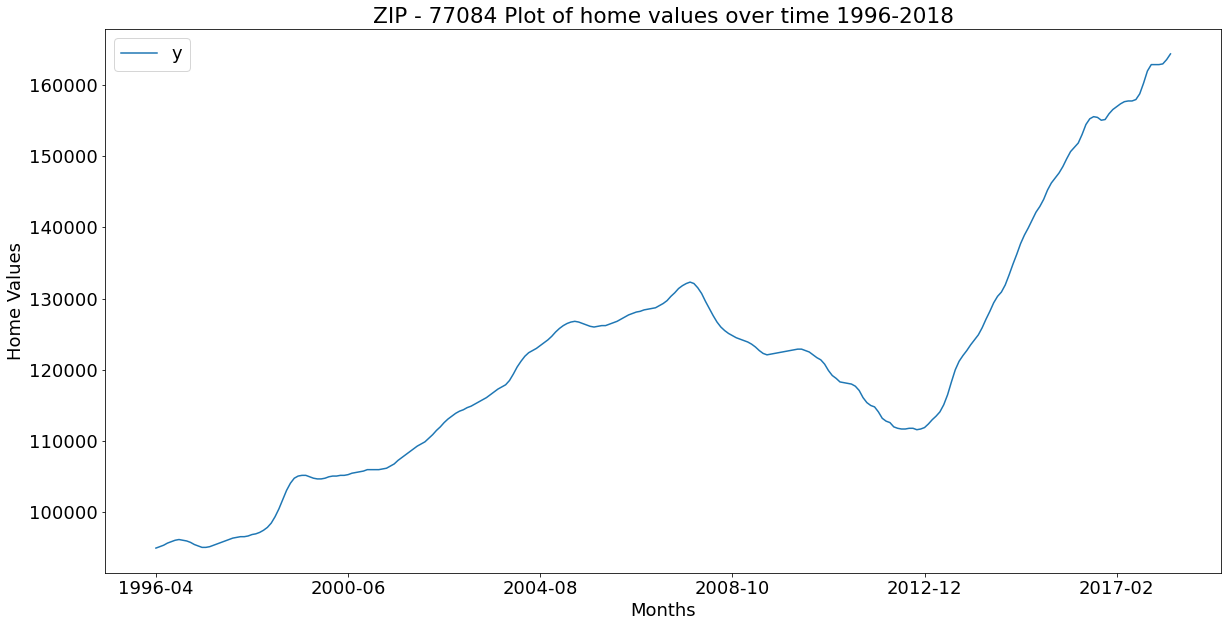

In [15]:
plt.figure()
plt.rcParams.update({'font.size': 18})
ax = df.plot(title='ZIP - 77084 Plot of home values over time 1996-2018', figsize=(20,10), x='ds')
ax.set_xlabel('Months')
ax.set_ylabel('Home Values')

# Fitting and forecasting the model
    1. The length of the forecast will be 5 years into the future.
    2. Periods = 60 with freq = M
        - 60 months / 12 months per year  = 5 years
    3. seasonality_mode = multiplicative
        - This is because additive would mean our graph will have a STEADY upward climb
        - This is not the case. There is a HUGE upward climb. Thus, multiplicative was used instead of additive.
        
### Observations:
    1. The trend shows promise, reflects the growth and demand of properties in the area.
    2. The 2008 crash is reflected in the dip in home prices. This should not be confused for a cyclical occurence.
    3. We cannot say much about seasonality. There is a huge upward trend.
        - Future work - maybe find stronger seasonality in daily data instead of monthly.

<Figure size 432x288 with 0 Axes>

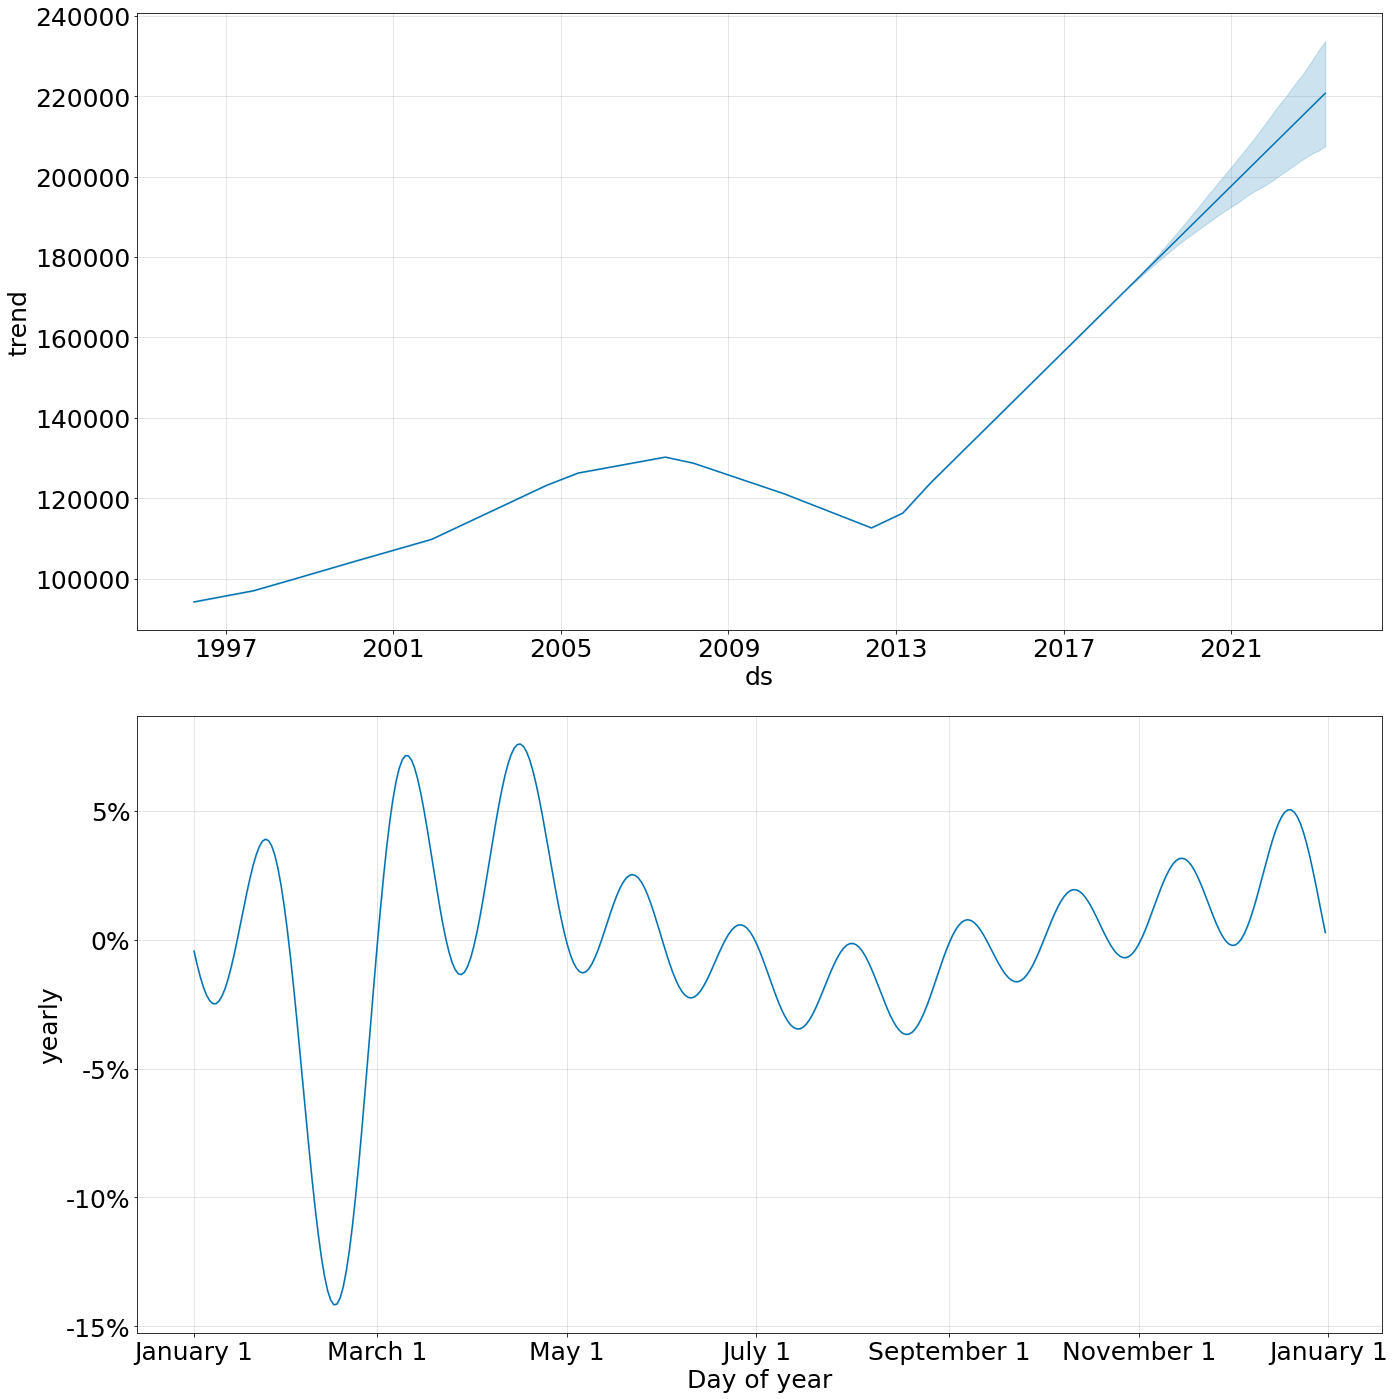

In [5]:
m = Prophet(seasonality_mode='multiplicative').fit(df)
future = m.make_future_dataframe(periods=60, freq='M')
fcst = m.predict(future)
plt.figure()
plt.rcParams.update({'font.size': 25})
fig = m.plot_components(fcst, figsize=(20,20))

In [6]:
fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
320,2022-11-30,217034.709600,204864.277676,228711.796498
321,2022-12-31,219161.873191,206592.560330,231206.406944
322,2023-01-31,220983.592396,207837.506245,233948.932625
323,2023-02-28,214899.557381,202288.826811,227546.616941
324,2023-03-31,218788.728888,205300.098029,231663.942035


# Forecast Model Diagnostics
## Here I will check the accuracy of the model using cross validation
### Cross validation parameters are as follows:
    1. Model will be "m" from above fitted by Prophet() method
    2. The initial training lengh parameter will be 5475 days or 15 years (365*15 = 5475)
        - This means cutoff will be after 15 years (1996 - 2011)
    3. The horizon will be 1825 days or 5 years (365 * 5 = 1825)
        - from 2012 - 2017
    4. The period is set to 180 days
        - Means it will make a prediction roughly every 6 months        

In [7]:
cv_results = cross_validation( model = m, initial = pd.to_timedelta(5475, unit="d"),period="180 days", horizon = pd.to_timedelta(1825,unit="d"))

In [8]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-05-01,117948.222349,116820.577308,119143.756905,118000.0,2011-04-13
1,2011-06-01,117649.533933,116485.975168,118734.432598,117700.0,2011-04-13
2,2011-07-01,117319.662262,116159.617033,118447.369368,117100.0,2011-04-13
3,2011-08-01,116948.712952,115775.149739,118141.317740,116100.0,2011-04-13
4,2011-09-01,116591.253748,115421.764822,117750.776126,115400.0,2011-04-13


### MSE observation:
    1. MSE starts to increase exponentially after 750-1000 days. 
    2. This reflects higher uncertainty the farther into the horizon

<Figure size 432x288 with 0 Axes>

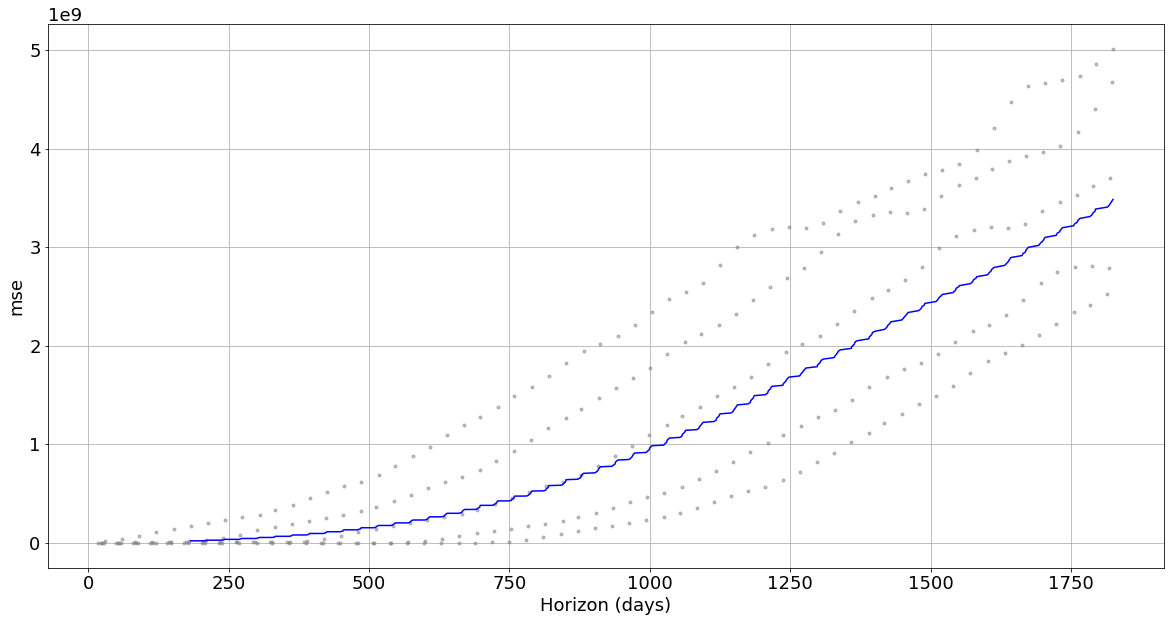

In [9]:
from fbprophet.plot import plot_cross_validation_metric
plt.figure()
plt.rcParams.update({'font.size': 18})
fig = plot_cross_validation_metric(cv_results, metric='mse', figsize=(20,10))

### RMSE Observation:
    1. Similar to MSE, the error increases with longer time into horizon

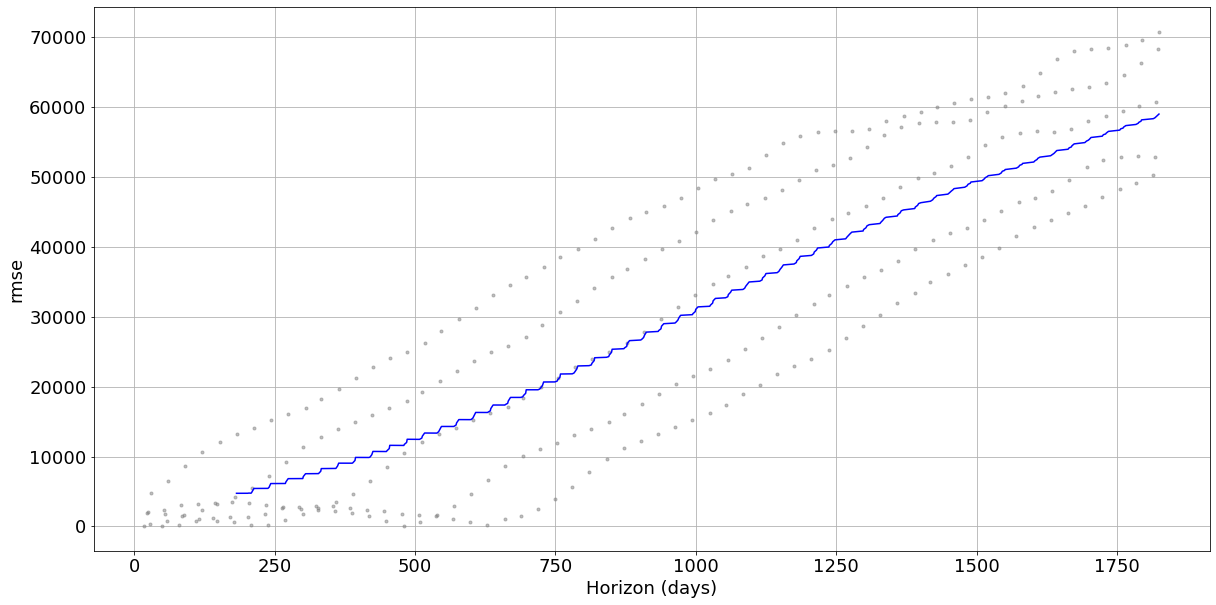

In [10]:
fig = plot_cross_validation_metric(cv_results, metric='rmse', figsize=(20,10))

### MAE - Mean Absolute Error Observation:
    1. Similar to MSE and RMSE, the difference starts increasing as the number of observations are increasing

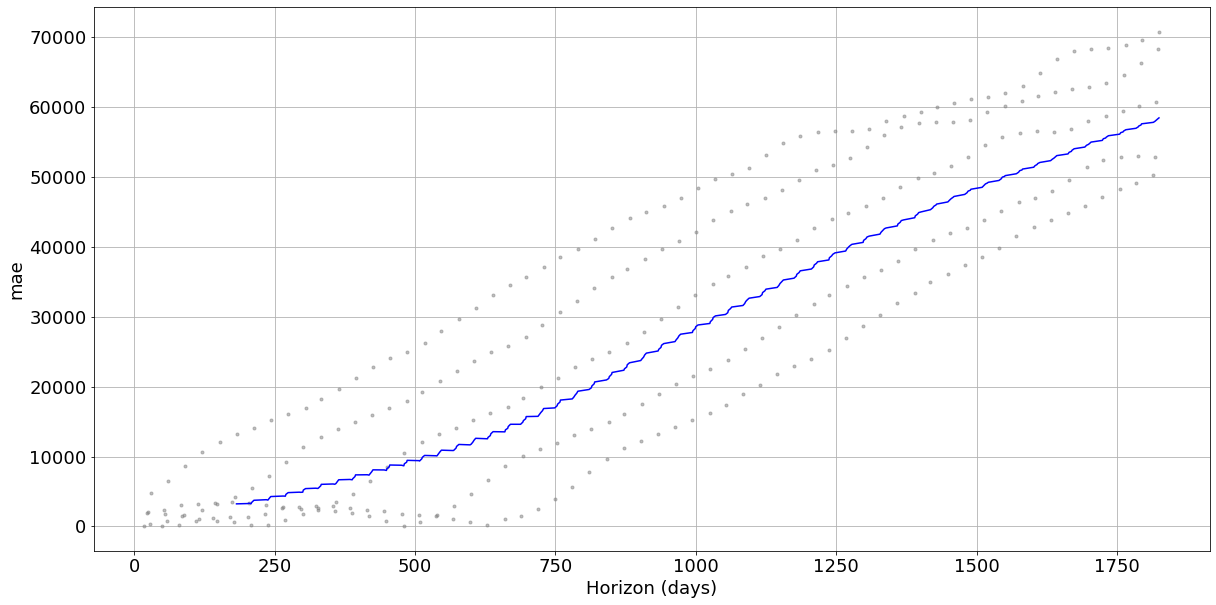

In [11]:
fig = plot_cross_validation_metric(cv_results, metric='mae', figsize=(20,10))

## MAPE (Mean Average Percent Error) - Observation:
    1. We see that MAPE increases over time
    2. I am willing to tolerate MAPE of 0.1 to 0.2
        - This gets exceeded after about 1100 days        
    3. We will focus on MAPE as our main diagnostic metric.
        - Shows the model was about 80% accurate at 1000 days
        - Bullish prediction for the next 2-3 years
        - Supports the high upward trend we saw in the graph of all the data points for the zip code

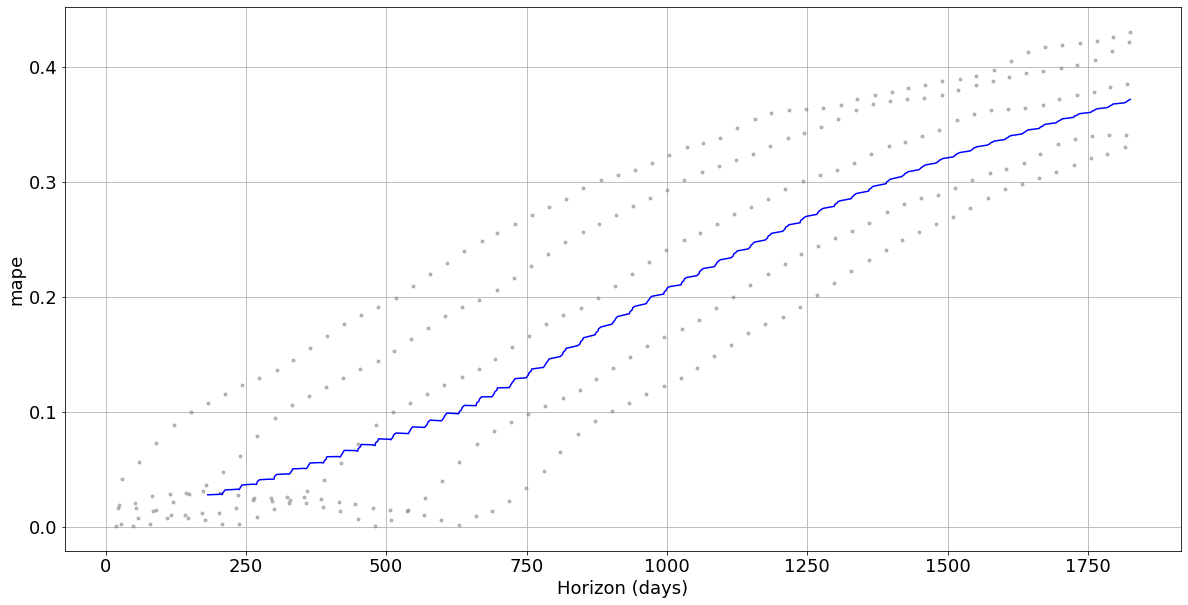

In [12]:
fig = plot_cross_validation_metric(cv_results, metric='mape', figsize=(20,10))

### Coverage Observation:
    1. We see coverage decreasing over time of horizon
    2. Shows 0 probability as we go past about 800 days. 
    3. Means after about 800 days there is no probability a true value will be in the predicted range. 
    4. This does not fully explain anything. Just shows the values are not in the predicted range after some time.

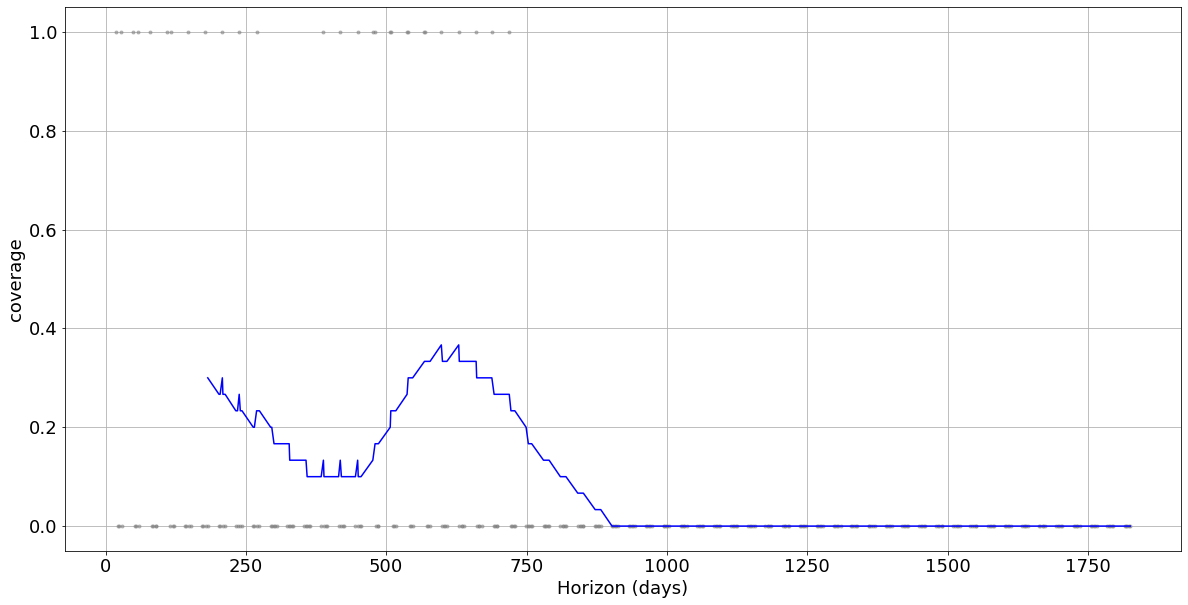

In [13]:
fig = plot_cross_validation_metric(cv_results, metric='coverage', figsize=(20,10))